In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Define Helper Function

In [2]:
def test_adfuller(array, array_name, alpha= 0.05):
    """adfuller test to test for stationarity
    null hypothesis: a unit root (root >= 1 or <= -1) is present (not stationary) 
    alternative hypothesis: a unit root is not present (stationary)

    Args:
        array (np.array): array to test
        array_name (string): array name to display
        alpha (float, optional): test alpha. Defaults to 0.05.
    """
    from statsmodels.tsa.stattools import adfuller
    adf_result= adfuller(array)
    adf_stats= adf_result[0]
    p_value= adf_result[1]

    print(f'{array_name}')
    print(f'\tADF Statistic: {adf_stats: .4}')
    print(f'\tp-value: {p_value: .4}')
    if p_value < alpha:
        print('\tp value < 0.05: we reject the H0 that our series is not stationary')
        print(f'\tconclusion: {array_name} is stationary')
    else:
        print('\tp value > 0.05: we cannot reject the H0 that our series is not stationary')
        print(f'\tconclusion: {array_name} is not stationary')

def search_optimal_diff(series, low= 0, high= 1):
    """find out how many times df need to be differenced to become stationary"""
    for i in range(low, (high+1)):
        data= np.diff(series, n= i)
        test_adfuller(data, f'JJ - {i} order differencing')

def optimize_sarima(endog: pd.Series, 
    ps: list, qs: list, d: int,
    Ps: list, Qs: list, D: int, s: int):
    """try all possible combinatios of the hyperparameter
    credit to Marco Peixeiro

    Args:
        endog (pd.Series)
        ps (list): list of p to try
        qs (list): list of q to try
        d (int): d
        Ps (list): list of P to try
        Qs (list): list of Q to try
        D (int): D
        s (int): s

    Returns:
        pd.DataFrame: dataframe with all combinations and their AIC
    """
    import warnings
    from itertools import product
    from statsmodels.tsa.statespace.sarimax import SARIMAX
    from tqdm import tqdm

    order_list= list(product(
        ps, [d], qs, 
        Ps, [D], Qs, [s])) # get all possible combinations of (p, d, q, P, D, Q, s)

    results= []
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore") # ! to ignore "Using zeros as starting parameters" warning
        for order in tqdm(order_list):
            model= (SARIMAX(
                endog= endog, 
                simple_differencing= False, 
                order= (order[0], order[1], order[2]), 
                seasonal_order= (order[3], order[4], order[5], order[6]) 
            ))
            result= model.fit(disp= False)
            aic= result.aic
            results.append((order, aic))

    df_results= pd.DataFrame(results, columns= ['(p, d, q, P, D, Q, s)', 'aic']).sort_values('aic', ascending= True)
    return df_results

def test_ljungbox(residuals):
    """ H0: The data are independently distributed (not correlated).
        Ha: The data are not independently distributed; they exhibit serial correlation.

    Args:
        residuals (residuals): SARIMAX result residuals

    Returns:
        pd.DataFrame: dataframe containing ljung-box test result
    """
    from statsmodels.stats.diagnostic import acorr_ljungbox
    df_res= acorr_ljungbox(residuals, np.arange(1, 11, 1))
    df_res= (df_res.assign(
        result= np.where(df_res['lb_pvalue'] > 0.05, 'residuals are not correlated', 'residuals are correlated')
    ))
    return df_res

## Load DF

In [3]:
path= 'data\daily-website-visitors.csv'
df= pd.read_csv(path, usecols= ['Date', 'Unique.Visits'], parse_dates= ['Date'])
df.head(5)

,Date,Unique.Visits
0,2014-09-14,"1,582"
1,2014-09-15,"2,528"
2,2014-09-16,"2,630"
3,2014-09-17,"2,614"
4,2014-09-18,"2,366"


## Clean DF

In [4]:
df= (df
    .rename(columns= lambda c: c.replace('.', '_').lower())
    .set_index('date') # set datetime as index
    .sort_index() # sort index
    .assign(
        # remove "," in the data, cast to int
        unique_visits= lambda df_: df_['unique_visits'].str.replace(',', '').astype('int')
    )
    .resample('1D').sum() # resample by 1 day to make sure there is mo missing value
    .interpolate() # interpolate for missing value (if any)
    .loc['2019-01-01': '2020-01'] # include data from 2005 - 2017 
)

df.head(5)

,unique_visits
date,
2019-01-01,1168
2019-01-02,2361
2019-01-03,2793
2019-01-04,2373
2019-01-05,1609


## Simple EDA

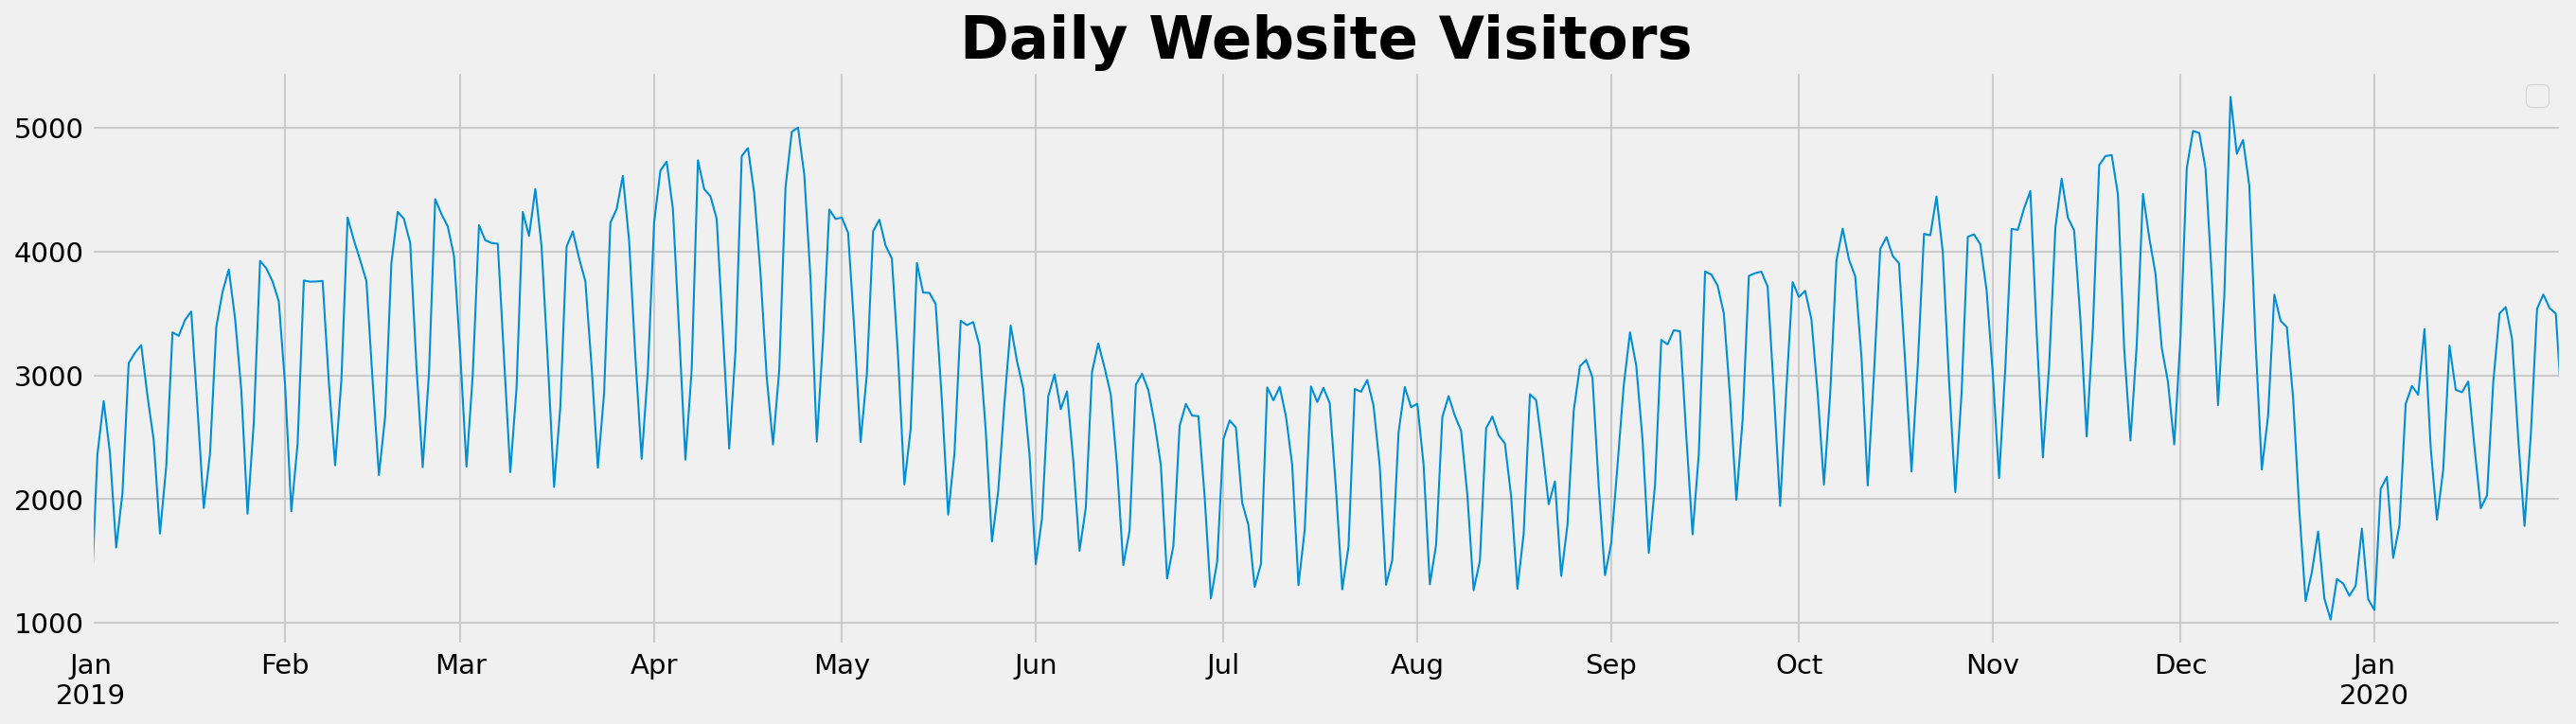

In [5]:
fig, ax= plt.subplots(figsize= (20, 5), dpi= 150)

(df
    .plot(
        kind= 'line', lw= 1,
        ax= ax
    )
)

ax.set_title('Daily Website Visitors', fontsize= 30, fontweight= 'bold')
ax.set_xlabel('')
ax.legend('')
plt.show()

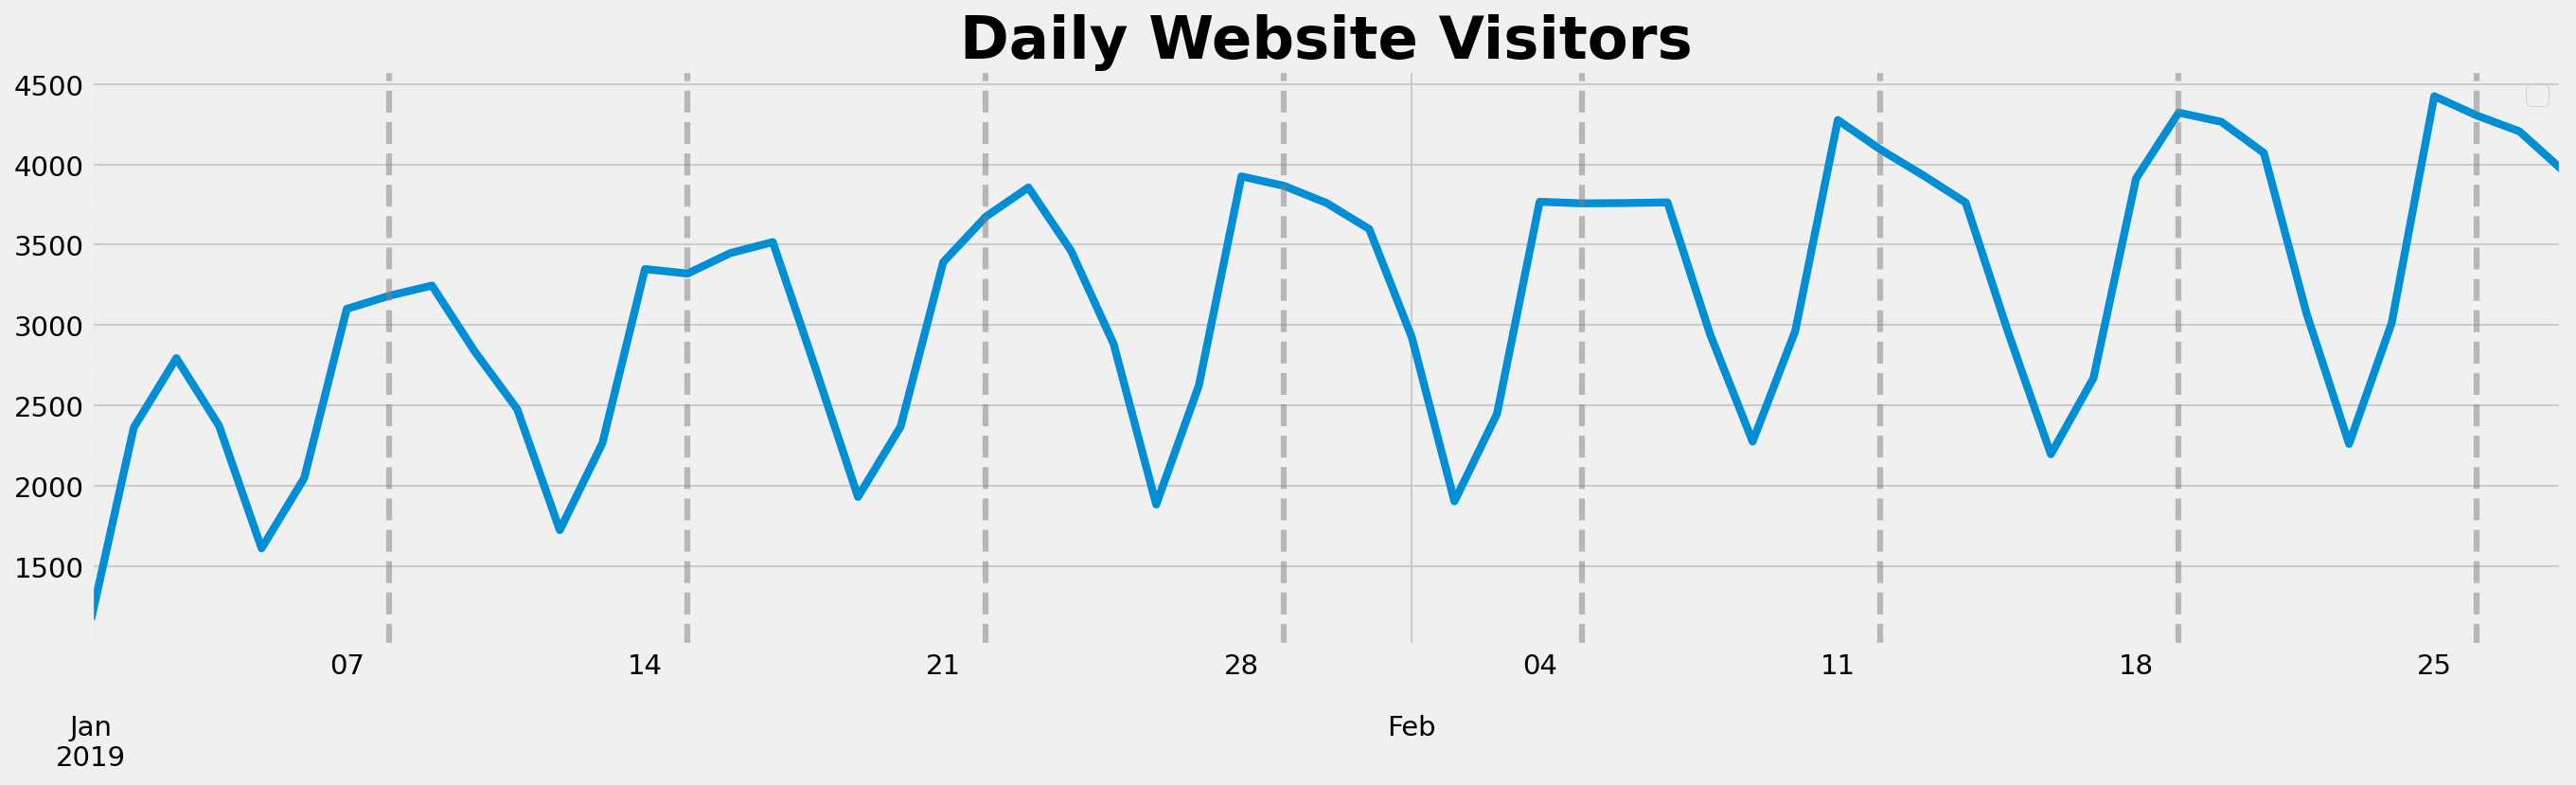

In [6]:
fig, ax= plt.subplots(figsize= (20, 5), dpi= 150)

(df
    .loc['2019':'2019-02'] # get a month of data
    .plot(
        kind= 'line', lw= 4,
        ax= ax
    )
)

ax.set_title('Daily Website Visitors', fontsize= 30, fontweight= 'bold')
ax.set_xlabel('')
ax.legend('')

for i in pd.date_range('2019-01-01', '2019-03-01', freq= '7D'):
    ax.axvline(x= i, color= 'grey', alpha= 0.5, linestyle= '--', linewidth= 3)

plt.show()

By placing a line every 7 days, we can see quite clearly that there are recurring patterns every week. Number of website visitors peaks every weekend.

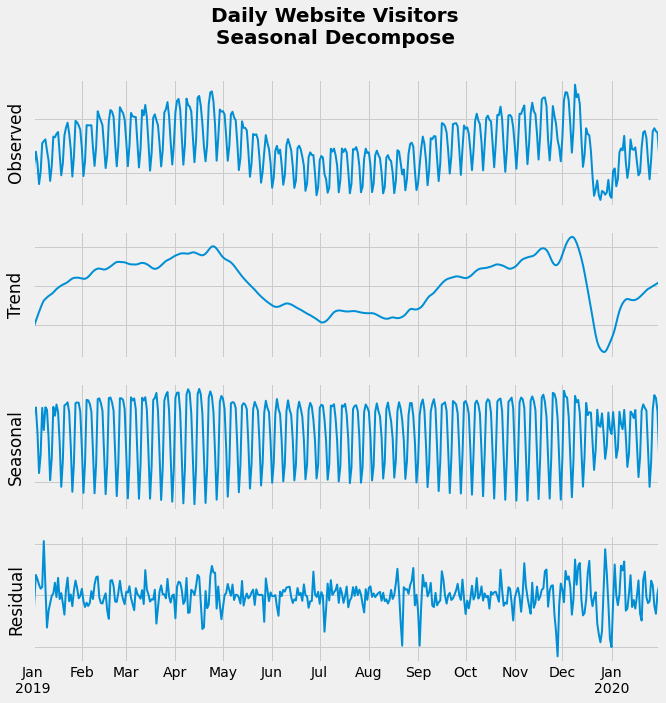

In [7]:
from statsmodels.tsa.seasonal import STL
fig, (ax1, ax2, ax3, ax4)= plt.subplots(nrows= 4, figsize= (10, 10), sharex= True)
res= STL(df, period= 7).fit()

res.observed.plot(ax= ax1, lw= 2)
res.trend.plot(ax= ax2, lw= 2)
res.seasonal.plot(ax= ax3, lw= 2)
res.resid.plot(ax= ax4, lw= 2)

ylabels= ['Observed', 'Trend', 'Seasonal', 'Residual']
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_ylabel(ylabels.pop(0))
    ax.set_xlabel('')
    ax.yaxis.set_ticklabels([])
    try:
        ax.get_legend().remove()
    except:
        pass

plt.suptitle('Daily Website Visitors\nSeasonal Decompose', fontweight= 'bold', fontsize= 20)
plt.show()

## Model Selection

In [8]:
search_optimal_diff(df['unique_visits'], low= 7, high= 7)

JJ - 7 order differencing
	ADF Statistic: -15.49
	p-value:  2.527e-28
	p value < 0.05: we reject the H0 that our series is not stationary
	conclusion: JJ - 7 order differencing is stationary


The data is stationary after first seasonal differencing. Meaning:<br>
- d= 1<br>
- D= 1<br>

After this, we will try different combinations of hyperparameters to search for hyperparameter combination that minimizes AIC.

In [9]:
len_test= len(df.loc['2020':'2020'])
train= df.iloc[-len_test:]
test= df.iloc[:-len_test]

ps= list(range(0, 4, 1))
qs= list(range(0, 4, 1))
d= 1

Ps= list(range(0, 4, 1))
Qs= list(range(0, 4, 1))
D= 1
s= 7 # number of period in a season (12 months in a year)

df_result= optimize_sarima(train['unique_visits'], ps, qs, d, Ps, Qs, D, s)
df_result

100%|██████████| 256/256 [02:09<00:00,  1.98it/s]


,"(p, d, q, P, D, Q, s)",aic
4,"(0, 1, 0, 1, 1, 0, 7)",340.125039
20,"(0, 1, 1, 1, 1, 0, 7)",341.653443
8,"(0, 1, 0, 2, 1, 0, 7)",341.671442
68,"(1, 1, 0, 1, 1, 0, 7)",341.757570
2,"(0, 1, 0, 0, 1, 2, 7)",342.012532
...,...,...
251,"(3, 1, 3, 2, 1, 3, 7)",355.555568
255,"(3, 1, 3, 3, 1, 3, 7)",357.530487
9,"(0, 1, 0, 2, 1, 1, 7)",681.667642
13,"(0, 1, 0, 3, 1, 1, 7)",795.243962


With this result, we will use SARIMA $(0, 1, 0)(1, 1, 0)_{7}$ model as it has the lowest AIC among our models.<br>
After this, we will analyze the residuals of our model.

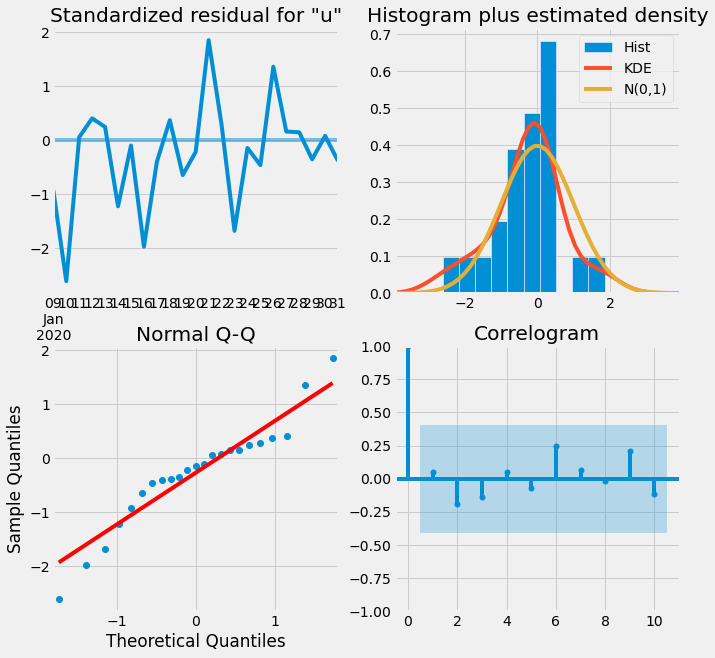

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model= SARIMAX(endog= train, order= (0, 1, 0), seasonal_order= (1, 1, 0, 7), simple_differencing= False)
model_fit= model.fit()
model_fit.plot_diagnostics(figsize= (10, 10))
plt.show()

In [11]:
test_ljungbox(model_fit.resid)

,lb_stat,lb_pvalue,result
1,2.300023,0.129372,residuals are not correlated
2,3.937721,0.139616,residuals are not correlated
3,5.485868,0.139486,residuals are not correlated
4,5.938167,0.203814,residuals are not correlated
5,6.935476,0.225483,residuals are not correlated
6,8.863650,0.181393,residuals are not correlated
7,9.337152,0.229348,residuals are not correlated
8,11.400365,0.180029,residuals are not correlated
9,11.879480,0.220189,residuals are not correlated
10,12.101418,0.278326,residuals are not correlated


Our quantitative test by Ljung-Box test tells us that all the results are not correlated. So does our qualitative test by graph. Therefore, we can continue to prediction.

In [12]:
def rolling_forecast(df: pd.DataFrame, col_name: str, train_len: int, horizon: int, window: int, method: str):
    """simulate sarimax prediction by each window

    Args:
        df (pd.DataFrame): dataframe containing all the data
        col_name (str): column name
        train_len (int): training length
        horizon (int): how many steps to forecast
        window (int): how many data point to forecast in a single time
        method (str): method to use

    Returns:
        pd.Series: series containing prediction
    """

    total_len= train_len + horizon

    if method== 'last_season_year':
        pred_last_season= []
        for i in range(train_len, total_len, window):
            last_season_year= df.iloc[i - 365].values
            last_season_year= list(last_season_year) * window
            pred_last_season.extend(last_season_year)
        pred_last_season= pred_last_season[:horizon] 
        return pred_last_season
    
    if method== 'sarima':
        pred_sarima= []
        for i in range(train_len, total_len, window):
            model= SARIMAX(df[col_name][:i], order= (0, 1, 0), seasonal_order= (1, 1, 0, 7), simple_differencing= False)
            model_fit= model.fit(disp= False)
            predictions= model_fit.get_prediction(0, (i + window - 1))
            oos_prediction= predictions.predicted_mean.iloc[-window:]
            pred_sarima.extend(oos_prediction)
        return pred_sarima

In [13]:
train_len= 365
horizon= 31
window= 1

df_pred= df.iloc[train_len:].copy()

df_pred= (df_pred
    .rename(columns= {'unique_visits': 'actual'})
    .assign(
        pred_last_season_year= rolling_forecast(df, 'unique_visits', train_len, horizon, 1, 'last_season_year'),
        pred_sarima= rolling_forecast(df, 'unique_visits', train_len, horizon, 1, 'sarima')
    )
)

## Plot Prediction Result and Score

In [14]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

y_true= df_pred['actual']
y_pred_sarima= df_pred['pred_sarima']
y_pred_last_season= df_pred['pred_last_season_year']

mape_sarima= mean_absolute_percentage_error(y_true, y_pred_sarima) * 100
mape_last_season= mean_absolute_percentage_error(y_true, y_pred_last_season) * 100

mae_sarima= mean_absolute_error(y_true, y_pred_sarima)
mae_last_season= mean_absolute_error(y_true, y_pred_last_season)

rmse_sarima= mean_squared_error(y_true, y_pred_sarima) ** 0.5
rmse_last_season= mean_squared_error(y_true, y_pred_last_season) ** 0.5

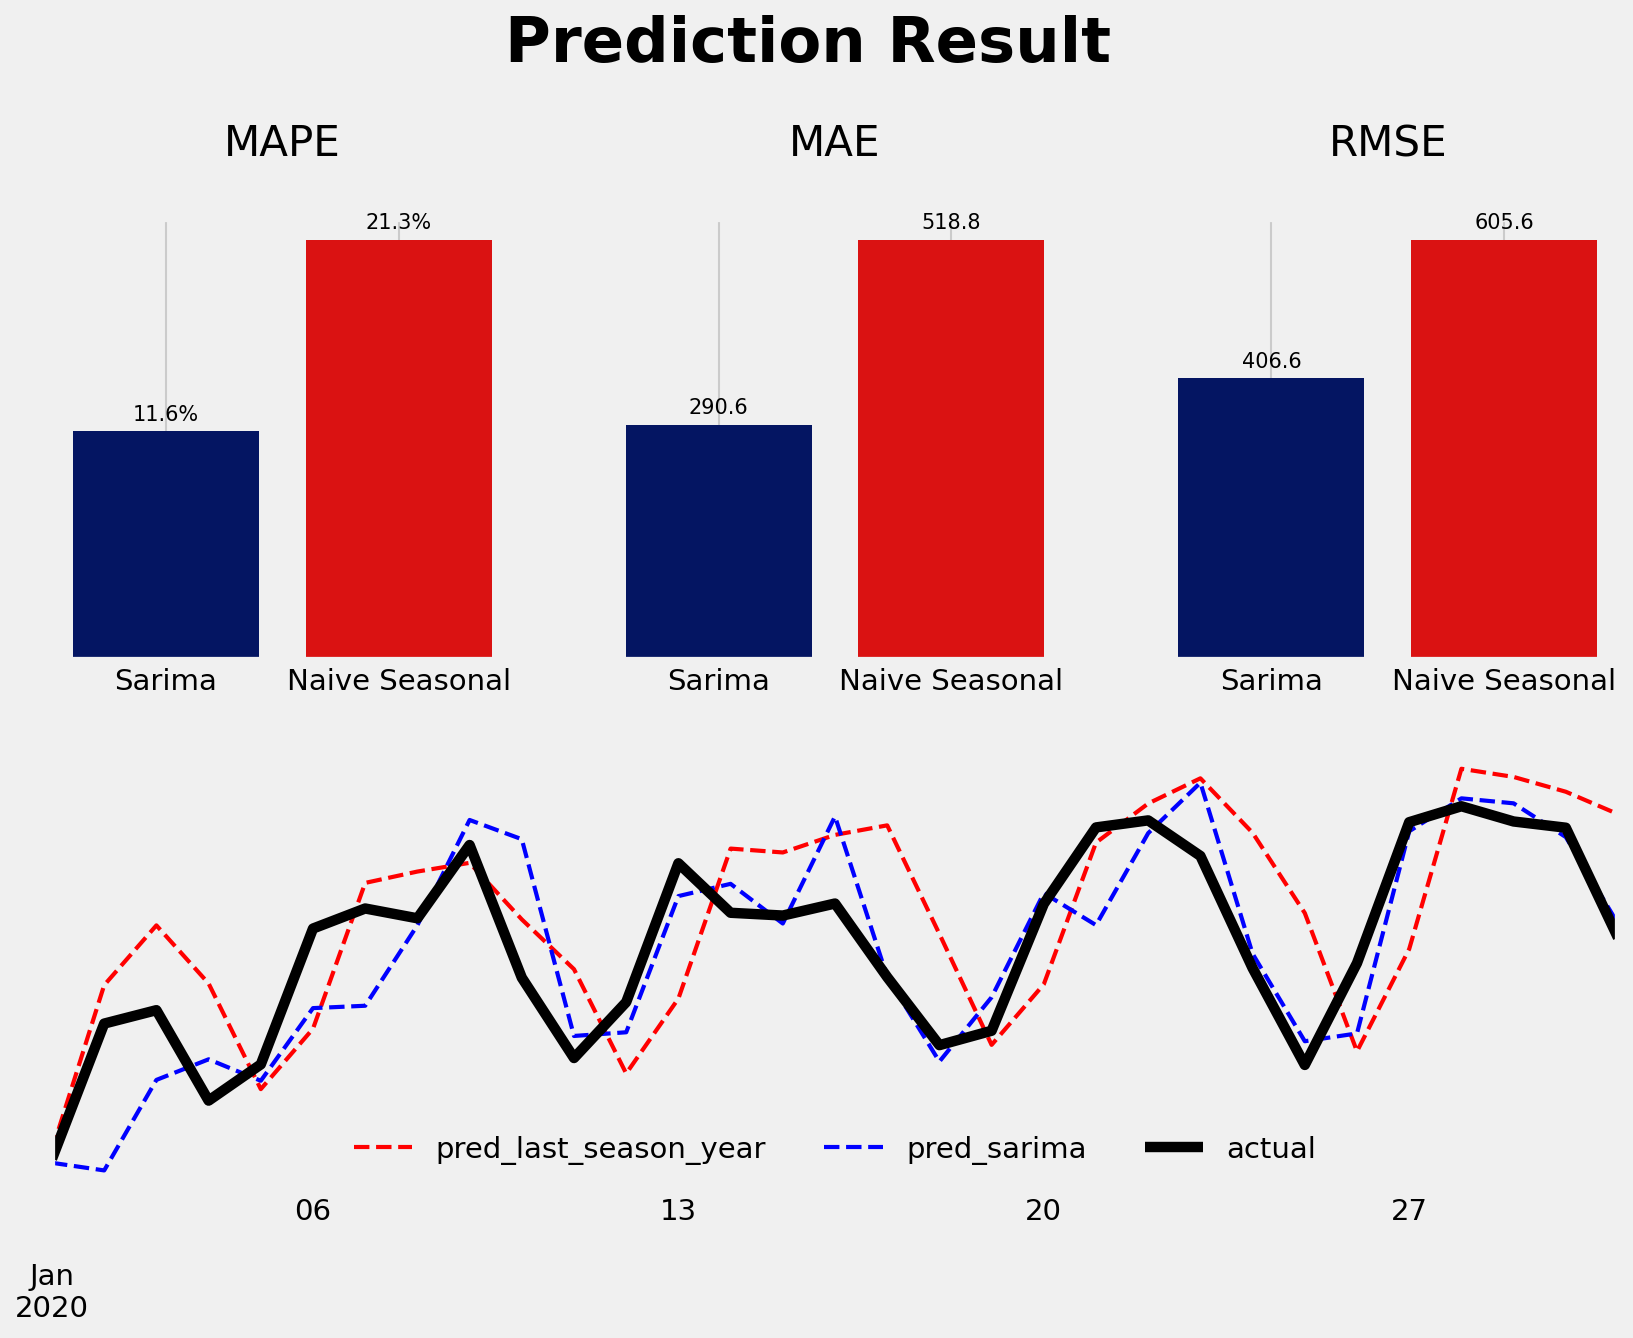

In [15]:
plt.figure(figsize=(12, 8), dpi= 150)
ax1 = plt.subplot(2,3,1)
ax2 = plt.subplot(2,3,2)
ax3 = plt.subplot(2,3,3)
ax4 = plt.subplot(2,1,2)
axes = [ax1, ax2, ax3, ax4]
labels= ['Sarima', 'Naive Seasonal']
mape= [mape_sarima, mape_last_season]
mae= [mae_sarima, mae_last_season]
rmse= [rmse_sarima, rmse_last_season]
bar_colors= ['#041562', '#DA1212']

# MAPE plot
ax1.bar(x= labels, height= mape, color= bar_colors)
ax1.set_title('MAPE', pad= 30)
# annotate MAPE plot
for bar in ax1.patches:
    ax1.annotate(
        format(bar.get_height()/100, '.1%'), # label
        (bar.get_x() + bar.get_width() / 2, # x
        bar.get_height()), # y
        ha='center', va='center', size= 10, xytext=(0, 8), textcoords='offset points'
    )

# MAE plot
ax2.bar(x= labels, height= mae, color= bar_colors)
ax2.set_title('MAE', pad= 30)

# RMSE plot
ax3.bar(x= labels, height= rmse, color= bar_colors)
ax3.set_title('RMSE', pad= 30)

# annotate MAE and RMSE plot
for ax in [ax2, ax3]:
    for bar in ax.patches:
        ax.annotate(
            format(bar.get_height(), '.1f'), # label
            (bar.get_x() + bar.get_width() / 2, # x
            bar.get_height()), # y
            ha='center', va='center', size= 10, xytext=(0, 8), textcoords='offset points'
        )  

# prediction result plot
df_pred[['pred_last_season_year', 'pred_sarima']].plot(
        kind= 'line', style= ['r--', 'b--'], lw= 2, ax= ax4)
df_pred['actual'].plot(
        kind= 'line', style= 'black', lw= 5, ax= ax4,  legend= 'Actual')
ax4.legend(ncol= 3, loc= 'lower center', frameon= False)

for ax in axes:
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.get_yaxis().set_visible(False)

plt.suptitle('Prediction Result', fontsize= 30, fontweight= 'bold', y= 1.05)
plt.savefig('image/pred_result.png', dpi=300, bbox_inches = "tight")
plt.show()